#Importing Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv1D,Conv1DTranspose,Concatenate,Input
import numpy as np
import IPython.display
import glob
from tqdm.notebook import tqdm
import librosa.display
import matplotlib.pyplot as plt

#Extracting Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!mkdir "/content/dataset/"
!mkdir "/content/dataset/CleanData"
!mkdir "/content/dataset/NoisyData"


In [ ]:
!unzip "/content/drive/MyDrive/NoiseSupressionData/clean_trainset_wav.zip" -d "/content/dataset/CleanData"
!unzip "/content/drive/MyDrive/NoiseSupressionData/noisy_trainset_wav.zip" -d "/content/dataset/NoisyData"

#Load the Data

In [2]:
clean_sounds = glob.glob('/content/dataset/CleanData/*')
noisy_sounds = glob.glob('/content/dataset/NoisyData/*')

In [3]:
len(clean_sounds)

11572

In [4]:
len(noisy_sounds)

11572

In [5]:
clean_sounds = clean_sounds[:2000]
noisy_sounds = noisy_sounds[:2000]

In [6]:
clean_sounds_list,_ = tf.audio.decode_wav(tf.io.read_file(clean_sounds[0]),desired_channels=1)
for i in tqdm(clean_sounds[1:]):
  so,_ = tf.audio.decode_wav(tf.io.read_file(i),desired_channels=1)
  clean_sounds_list = tf.concat((clean_sounds_list,so),0)

noisy_sounds_list,_ = tf.audio.decode_wav(tf.io.read_file(noisy_sounds[0]),desired_channels=1)
for i in tqdm(noisy_sounds[1:]):
  so,_ = tf.audio.decode_wav(tf.io.read_file(i),desired_channels=1)
  noisy_sounds_list = tf.concat((noisy_sounds_list,so),0)

clean_sounds_list.shape,noisy_sounds_list.shape

# RUNNING THIS CELL takes: GPU:13GB

  0%|          | 0/1999 [00:00<?, ?it/s]

  0%|          | 0/1999 [00:00<?, ?it/s]

(TensorShape([94770608, 1]), TensorShape([94770608, 1]))

In [7]:
batching_size = 12000
# batching_size = 800
# batching_size = 8

clean_train,noisy_train = [],[]

for i in tqdm(range(0,clean_sounds_list.shape[0]-batching_size,batching_size)):
  clean_train.append(clean_sounds_list[i:i+batching_size])
  noisy_train.append(noisy_sounds_list[i:i+batching_size])

clean_train = tf.stack(clean_train)
clean_train.shape


  0%|          | 0/7897 [00:00<?, ?it/s]

TensorShape([7897, 12000, 1])

In [8]:
gpu_options = tf.compat.v1.GPUOptions(allow_growth=True)
session = tf.compat.v1.InteractiveSession(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

noisy_train = tf.stack(noisy_train)
noisy_train.shape

TensorShape([7897, 12000, 1])

# Create a tf.data.Dataset

In [9]:
def get_dataset(x_train,y_train):
  dataset = tf.data.Dataset.from_tensor_slices((x_train,y_train))
  dataset = dataset.shuffle(100).batch(64,drop_remainder=True)
  return dataset

In [12]:
len(clean_train)

7897

In [13]:
# train_dataset = get_dataset(noisy_train[:40000],clean_train[:40000])
# test_dataset = get_dataset(noisy_train[40000:],clean_train[40000:])
train_dataset = get_dataset(noisy_train[:5000],clean_train[:5000])
test_dataset = get_dataset(noisy_train[5000:],clean_train[5000:])

#Reviewing Sample Waveform

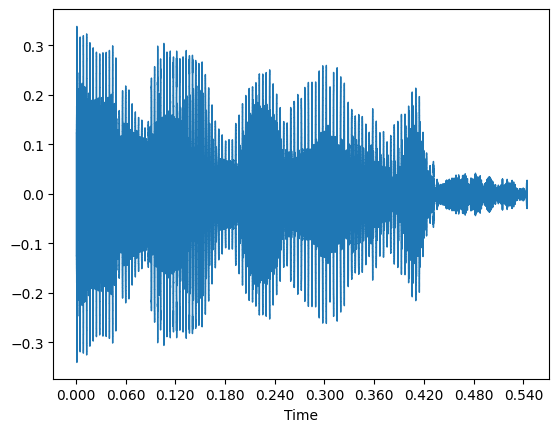

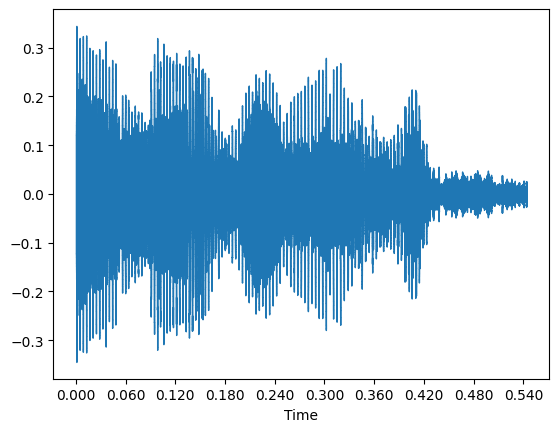

In [14]:
librosa.display.waveshow(np.squeeze(clean_train[5].numpy(),axis=-1))
plt.show()
librosa.display.waveshow(np.squeeze(noisy_train[5].numpy(),axis=-1))
plt.show()


#Creating the Model

In [15]:
# series_input = Input(shape = (series_input_train.shape[1],1,))
# inp = None,series_input
inp = Input(shape=(batching_size,1))
c1 = Conv1D(2,32,2,'same',activation='relu')(inp)
c2 = Conv1D(4,32,2,'same',activation='relu')(c1)
c3 = Conv1D(8,32,2,'same',activation='relu')(c2)
c4 = Conv1D(16,32,2,'same',activation='relu')(c3)
c5 = Conv1D(32,32,2,'same',activation='relu')(c4)

dc1 = Conv1DTranspose(32,32,1,padding='same')(c5)
conc = Concatenate()([c5,dc1])
dc2 = Conv1DTranspose(16,32,2,padding='same')(conc)
conc = Concatenate()([c4,dc2])
dc3 = Conv1DTranspose(8,32,2,padding='same')(conc)
conc = Concatenate()([c3,dc3])
dc4 = Conv1DTranspose(4,32,2,padding='same')(conc)
conc = Concatenate()([c2,dc4])
dc5 = Conv1DTranspose(2,32,2,padding='same')(conc)
conc = Concatenate()([c1,dc5])
dc6 = Conv1DTranspose(1,32,2,padding='same')(conc)
conc = Concatenate()([inp,dc6])
dc7 = Conv1DTranspose(1,32,1,padding='same',activation='linear')(conc)
model = tf.keras.models.Model(inp,dc7)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 12000, 1)]   0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 6000, 2)      66          ['input_1[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 3000, 4)      260         ['conv1d[0][0]']                 
                                                                                                  
 conv1d_2 (Conv1D)              (None, 1500, 8)      1032        ['conv1d_1[0][0]']               
                                                                                              

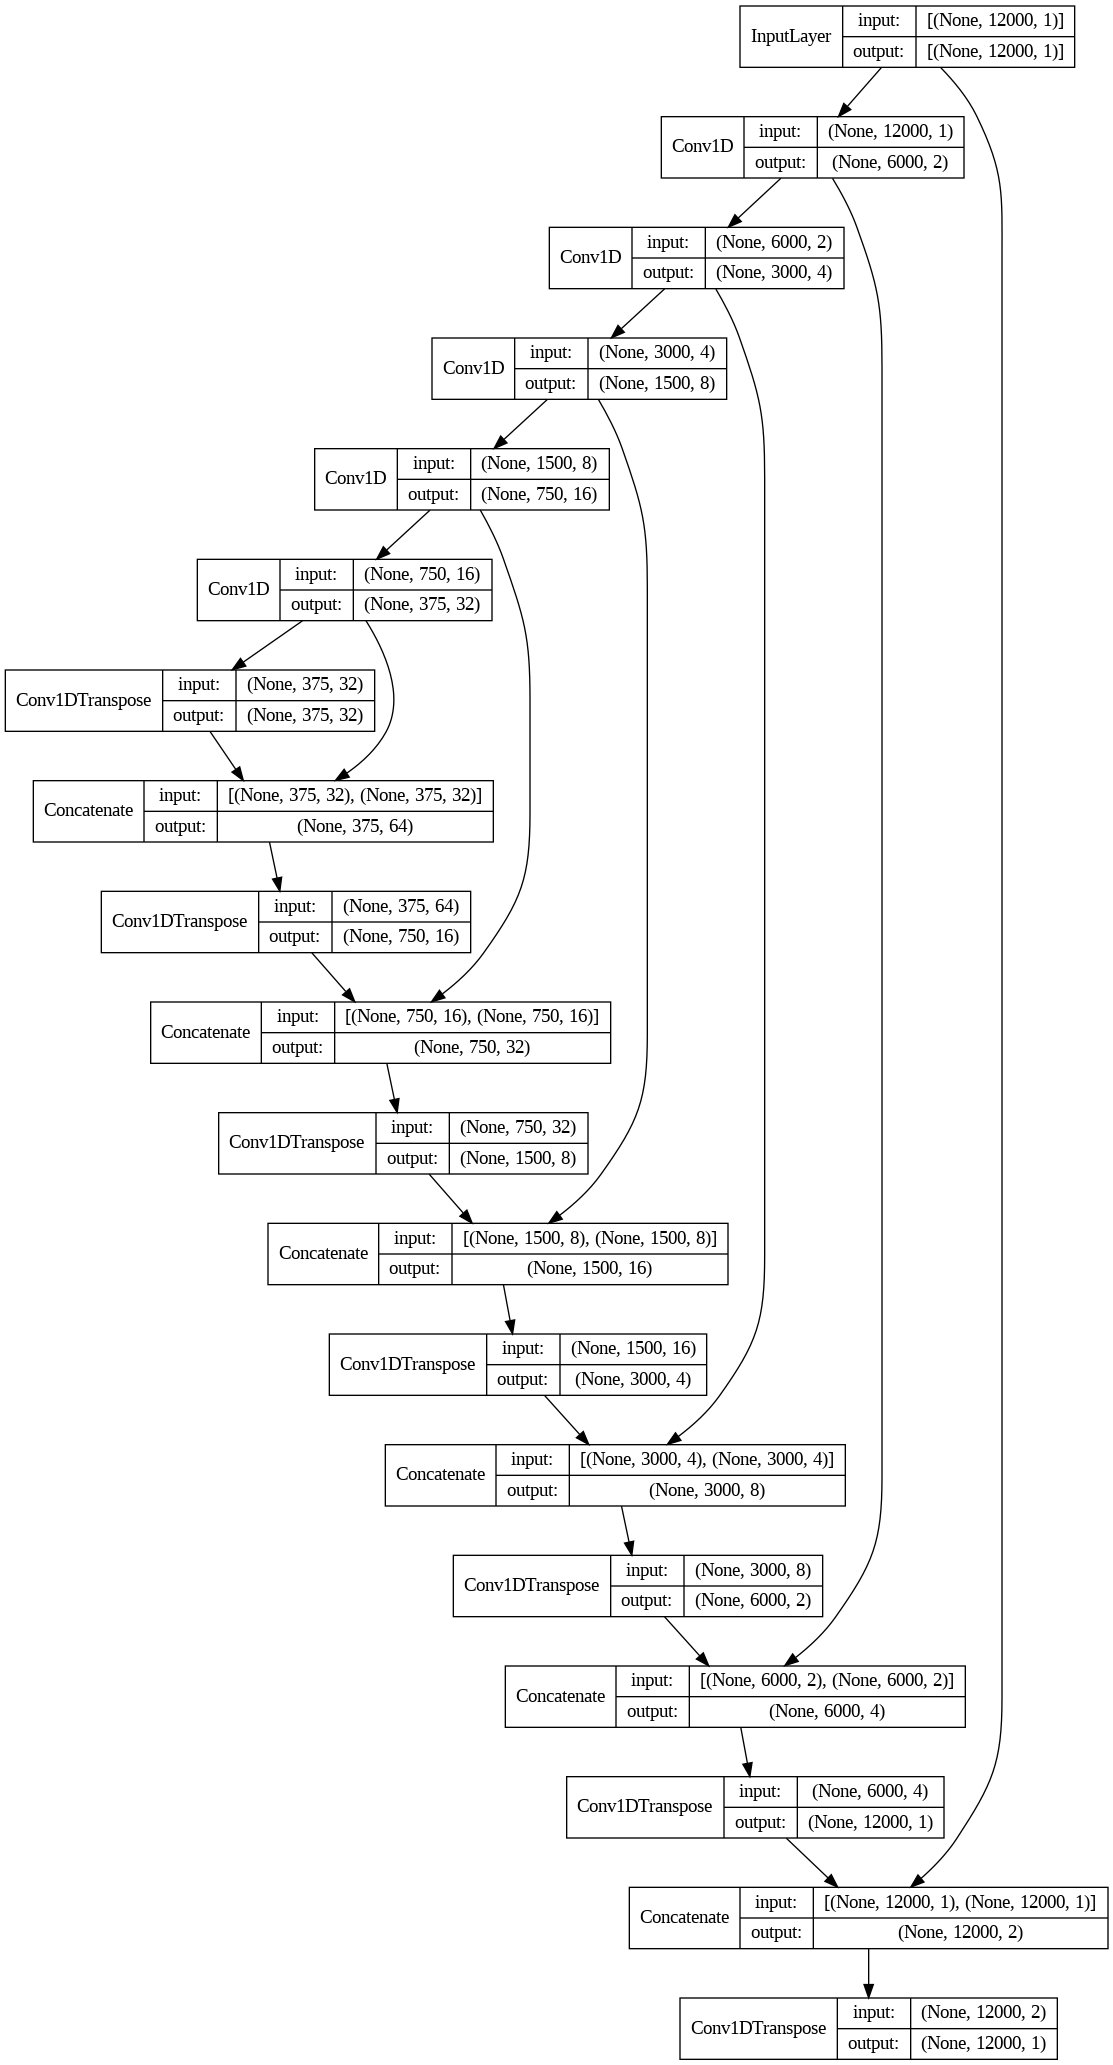

In [16]:
tf.keras.utils.plot_model(model,show_shapes=True,show_layer_names=False)

#Training

In [17]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.002),loss=tf.keras.losses.MeanAbsoluteError())
history = model.fit(train_dataset,epochs=20)

Epoch 1/20
78/78 [==============================] - 13s 26ms/step - loss: 0.0274
Epoch 2/20
78/78 [==============================] - 2s 22ms/step - loss: 0.0193
Epoch 3/20
78/78 [==============================] - 2s 21ms/step - loss: 0.0176
Epoch 4/20
78/78 [==============================] - 2s 20ms/step - loss: 0.0166
Epoch 5/20
78/78 [==============================] - 2s 20ms/step - loss: 0.0159
Epoch 6/20
78/78 [==============================] - 2s 21ms/step - loss: 0.0153
Epoch 7/20
78/78 [==============================] - 2s 22ms/step - loss: 0.0150
Epoch 8/20
78/78 [==============================] - 2s 20ms/step - loss: 0.0146
Epoch 9/20
78/78 [==============================] - 2s 20ms/step - loss: 0.0145
Epoch 10/20
78/78 [==============================] - 2s 20ms/step - loss: 0.0141
Epoch 11/20
78/78 [==============================] - 2s 21ms/step - loss: 0.0140
Epoch 12/20
78/78 [==============================] - 2s 20ms/step - loss: 0.0138
Epoch 13/20
78/78 [=================

#Testing Samples

In [21]:
from IPython.display import Audio
Audio(np.squeeze(noisy_train[10].numpy()),rate=16000)

In [22]:
Audio(tf.squeeze(model.predict(tf.expand_dims(tf.expand_dims(noisy_train[10],-1),0))),rate=16000)

1/1 [==============================] - 0s 35ms/step


In [23]:
model.evaluate(test_dataset)

45/45 [==============================] - 1s 12ms/step - loss: 0.0131


0.013110063038766384

In [24]:
model.save('NoiseSuppressionModel_Model2.h5')